In [29]:
# import libraries
import numpy as np
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

In [15]:
# import dataset (comes with colab!)
data = np.loadtxt(open('../more-on-data/mnist_train_small.csv','rb'),delimiter=',')

# extract labels (number IDs) and remove from data
labels = data[:,0]
data   = data[:,1:]

# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

In [16]:
# Step 1: convert to tensor
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long()

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)

# Step 3: convert into PyTorch Datasets
train_data = torch.utils.data.TensorDataset(train_data,train_labels)
test_data  = torch.utils.data.TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [17]:
# create a class for the model
def createTheMNISTNet():

  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,64)
      
      ### hidden layer
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)

      ### output layer
      self.output = nn.Linear(32,10)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return self.output(x)
  
  # create the model instance
  net = mnistNet()
  
  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.01)

  return net,lossfun,optimizer

In [18]:
tmpnet = createTheMNISTNet()[0]
print(tmpnet)

print('\n\nWeights for layer fc1:')
print(tmpnet.fc1.weight.data)

mnistNet(
  (input): Linear(in_features=784, out_features=64, bias=True)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=10, bias=True)
)


Weights for layer fc1:
tensor([[ 0.0503,  0.1237,  0.0123,  ...,  0.0358,  0.0925,  0.0085],
        [ 0.0467, -0.0348,  0.0206,  ...,  0.0038,  0.0879,  0.1186],
        [ 0.1174, -0.0288,  0.0710,  ..., -0.0428,  0.1158, -0.0406],
        ...,
        [-0.0142,  0.0089,  0.0481,  ...,  0.0676,  0.0337,  0.0392],
        [-0.0892, -0.0930, -0.0227,  ..., -0.0343, -0.0364, -0.0624],
        [ 0.0381, -0.0476,  0.0409,  ..., -0.0371,  0.0640,  0.0524]])


In [19]:
def function2trainTheModel(net,lossfun,optimizer):

  # number of epochs
  numepochs = 10
  
  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):

    # switch on train mode
    net.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,dim=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      
    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,dim=1)==y).float()) )
  # end epochs

  # function output
  return trainAcc,testAcc,losses,net

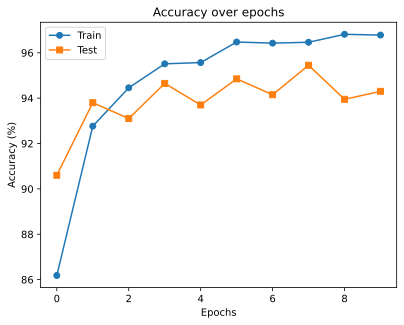

In [20]:
# Run the model without changing the weights; this will be the baseline performance.
# Notice the model creation is outside the function2train
net_base,lossfun,optimizer = createTheMNISTNet()
trainAcc_base,testAcc_base,losses,net_base = function2trainTheModel(net_base,lossfun,optimizer)

# plot the results
plt.plot(range(len(trainAcc_base)),trainAcc_base,'o-', range(len(testAcc_base)),testAcc_base ,'s-')
plt.legend(['Train','Test'])
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.show()

In [21]:
# Change the weights before training
net_zero,lossfun,optimizer = createTheMNISTNet()

# set to zeros
net_zero.fc1.weight.data = torch.zeros_like( net_zero.fc1.weight )

# confirm
net_zero.fc1.weight.data

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

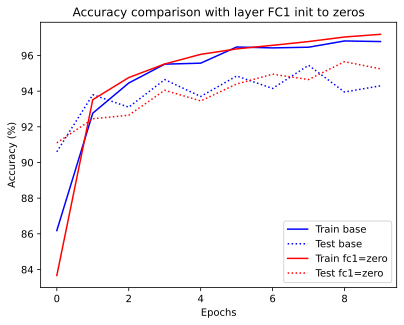

In [22]:
# run the model and show the results
trainAcc_zero,testAcc_zero,losses,net_zero = function2trainTheModel(net_zero,lossfun,optimizer)

plt.plot(range(len(trainAcc_base)),trainAcc_base,'b-', range(len(testAcc_base)),testAcc_base ,'b:')
plt.plot(range(len(trainAcc_zero)),trainAcc_zero,'r-', range(len(testAcc_zero)),testAcc_zero ,'r:')
plt.legend(['Train base','Test base','Train fc1=zero','Test fc1=zero'])
plt.title('Accuracy comparison with layer FC1 init to zeros')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.show()

tensor([[ 0.1464,  0.2024, -0.9417,  ...,  0.6144,  0.3983,  0.5346],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.1313,  0.4839, -0.6384,  ..., -0.3864, -0.1022, -0.5130],
        ...,
        [-0.0059, -0.4941,  0.2976,  ...,  0.0578, -0.3397, -0.4976],
        [ 0.1269, -0.5346, -0.4379,  ..., -1.2664,  0.0824, -0.6918],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])


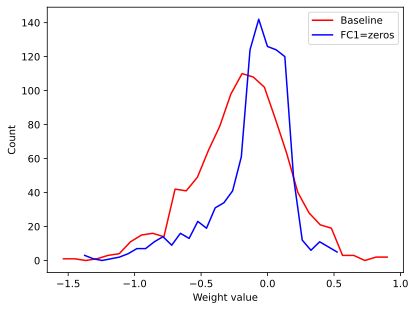

In [23]:
# Are the weights still zeros?
print(net_zero.fc1.weight.data)

# show the distributions in a histogram
y,x = np.histogram(net_base.fc2.weight.data.flatten(),30)
plt.plot((x[1:]+x[:-1])/2,y,'r',label='Baseline')

y,x = np.histogram(net_zero.fc2.weight.data.flatten(),30)
plt.plot((x[1:]+x[:-1])/2,y,'b',label='FC1=zeros')

plt.legend()
plt.xlabel('Weight value')
plt.ylabel('Count')
plt.show()

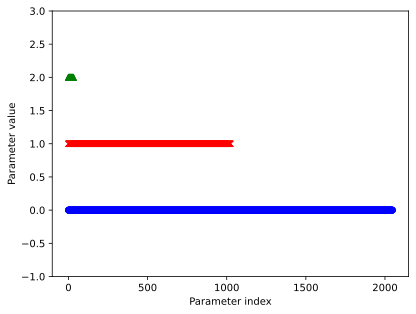

In [24]:
# Change the weights before training
net_allzero,lossfun,optimizer = createTheMNISTNet()

# loop over parameters and set them all to zeros
for p in net_allzero.named_parameters():
  p[1].data = torch.zeros_like( p[1].data )


# and confirm for a few select parameters (y-axis offset for visibility)
plt.plot(0+net_allzero.fc1.weight.data.flatten(),'bo')
plt.plot(1+net_allzero.fc2.weight.data.flatten(),'rx')
plt.plot(2+net_allzero.fc1.bias.data.flatten(),'g^')
plt.xlabel('Parameter index')
plt.ylim([-1,3])
plt.ylabel('Parameter value')
plt.show()

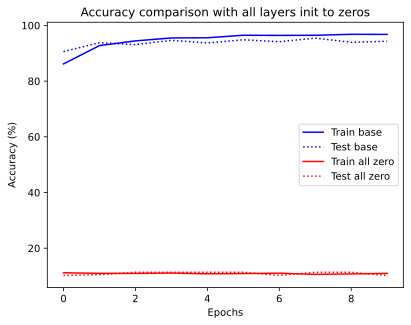

In [25]:
# run the model and show the results
trainAcc_allzero,testAcc_allzero,losses,net_allzero = function2trainTheModel(net_allzero,lossfun,optimizer)

plt.plot(range(len(trainAcc_base)),trainAcc_base,'b-', range(len(testAcc_base)),testAcc_base ,'b:')
plt.plot(range(len(trainAcc_allzero)),trainAcc_allzero,'r-', range(len(testAcc_allzero)),testAcc_allzero ,'r:')
plt.legend(['Train base','Test base','Train all zero','Test all zero'])
plt.title('Accuracy comparison with all layers init to zeros')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.show()

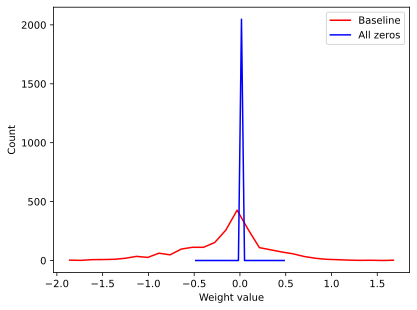

In [26]:
# show the distributions in a histogram
y,x = np.histogram(net_base.fc1.weight.data.flatten(),30)
plt.plot((x[1:]+x[:-1])/2,y,'r',label='Baseline')

y,x = np.histogram(net_allzero.fc1.weight.data.flatten(),30)
plt.plot((x[1:]+x[:-1])/2,y,'b',label='All zeros')

plt.legend()
plt.xlabel('Weight value')
plt.ylabel('Count')
plt.show()

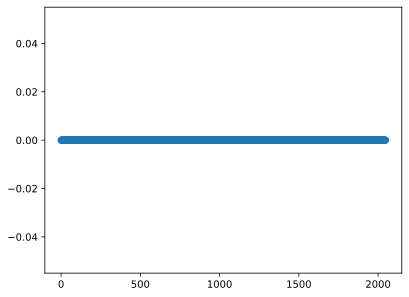

In [27]:
plt.plot(net_allzero.fc1.weight.data.flatten(),'o');

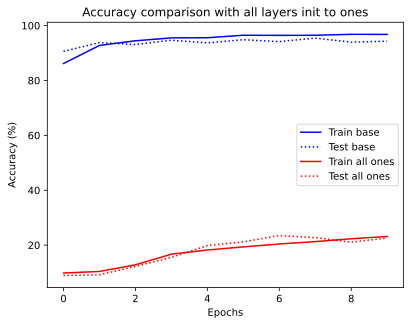

In [28]:
# Change the weights before training
net_allone,lossfun,optimizer = createTheMNISTNet()
for p in net_allone.named_parameters():
  p[1].data = torch.zeros_like( p[1].data ) + 1
  #p[1].data = torch.zeros( p[1].data.shape ) + 1 # equivalent to the previous line!


# run the model and show the results
trainAcc_allone,testAcc_allone,losses,net_allone = function2trainTheModel(net_allone,lossfun,optimizer)

plt.plot(range(len(trainAcc_base)),trainAcc_base,'b-', range(len(testAcc_base)),testAcc_base ,'b:')
plt.plot(range(len(trainAcc_allone)),trainAcc_allone,'r-', range(len(testAcc_allone)),testAcc_allone ,'r:')
plt.legend(['Train base','Test base','Train all ones','Test all ones'])
plt.title('Accuracy comparison with all layers init to ones')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.show()

## Experimenting with weight inits

In [30]:
# note: takes ~6 mins with 25 stdevs

# range of standard deviations to use
stdevs = np.logspace(np.log10(.0001),np.log10(10),25)

# number of histogram bins for plotting distributions
nhistBins = 80

# initialize results output matrix
accresults = np.zeros(len(stdevs))
histodata  = np.zeros((len(stdevs),2,nhistBins))



# Start the timer!
startTime = time.process_time()

# now to really start the experiment
for idx,std in enumerate(stdevs):

  # create the network
  net,lossfun,optimizer = createTheMNISTNet()

  # set all parameters according to the standard deviation
  for p in net.named_parameters():
    p[1].data = torch.randn_like( p[1].data ) * std
  

  # train the model
  trainAcc,testAcc,losses,net = function2trainTheModel(net,lossfun,optimizer)

  # get test accuracy on final 3 runs (averaging increases stability)
  accresults[idx] = np.mean( testAcc[-3:] )

  # collect all parameters into one vector and compute its histogram
  tmpparams = np.array([])
  for p in net.named_parameters():
    tmpparams = np.concatenate( (tmpparams,p[1].data.numpy().flatten()),axis=0 )
  
  # now compute their histogram
  y,x = np.histogram(tmpparams,nhistBins)
  histodata[idx,0,:] = (x[1:]+x[:-1])/2
  histodata[idx,1,:] = y

  # status report
  timeElapsed = time.process_time() - startTime
  print(f'Finished {idx+1}/{len(stdevs)} after {timeElapsed:3.0f}s. Model accuracy was {accresults[idx]:.2f}%.')

Finished 1/25 after 177s. Model accuracy was 11.35%.
Finished 2/25 after 349s. Model accuracy was 94.02%.
Finished 3/25 after 525s. Model accuracy was 94.33%.
Finished 4/25 after 701s. Model accuracy was 93.50%.
Finished 5/25 after 875s. Model accuracy was 92.27%.
Finished 6/25 after 1051s. Model accuracy was 93.28%.
Finished 7/25 after 1227s. Model accuracy was 92.55%.
Finished 8/25 after 1407s. Model accuracy was 93.73%.
Finished 9/25 after 1585s. Model accuracy was 94.17%.
Finished 10/25 after 1763s. Model accuracy was 92.80%.
Finished 11/25 after 1939s. Model accuracy was 92.80%.
Finished 12/25 after 2113s. Model accuracy was 94.23%.
Finished 13/25 after 2288s. Model accuracy was 94.73%.
Finished 14/25 after 2464s. Model accuracy was 95.57%.
Finished 15/25 after 2642s. Model accuracy was 95.07%.
Finished 16/25 after 2820s. Model accuracy was 95.22%.
Finished 17/25 after 2994s. Model accuracy was 94.58%.
Finished 18/25 after 3170s. Model accuracy was 94.40%.
Finished 19/25 after 334

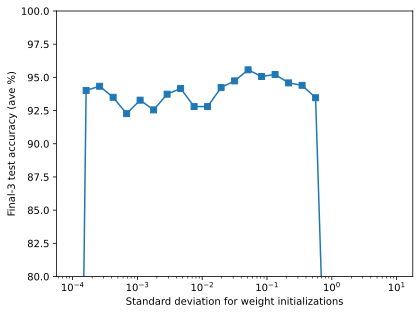

In [31]:
# Show the results!
plt.plot(stdevs,accresults,'s-')
plt.xlabel('Standard deviation for weight initializations')
plt.ylabel('Final-3 test accuracy (ave %)')
plt.xscale('log')
plt.ylim([80,100])
plt.show()

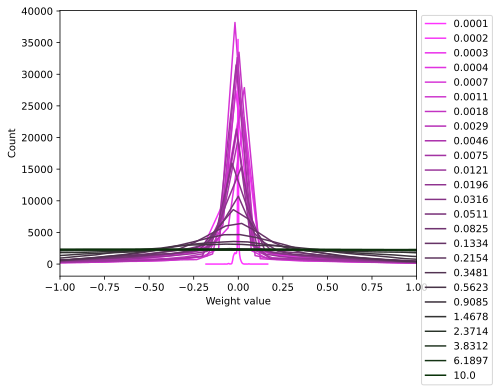

In [33]:
# show the weights distributions
for i in range(len(stdevs)):
  plt.plot(histodata[i,0,:],histodata[i,1,:],color=[1-i/len(stdevs),.2,1-i/len(stdevs)])

plt.xlabel('Weight value')
plt.ylabel('Count')
plt.legend(np.round(stdevs,4),bbox_to_anchor=(1,1),loc='upper left')
plt.xlim([-1,1])
plt.show()